# Predicting Sequential Data
In this notebook we'll use an MLP to predict the Max Daily Temperature and Rainfall. <br>
The MLP will take in a sequence of days and predict the information for the next day. By setting day_range larger than (days_in + 1) we can see what happens when we feed the models prediction back in as an input during training. The hope is that the model will become robust to any of it's own prediction errors and be able to predict further into the future.

[Corresponding Tutorial Video](https://youtu.be/iKZzXisK1-Q)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from Dataset import WeatherDataset

### Max Daily Temp and Rainfall Dataset

In [2]:
# Path to the CSV file containing the weather dataset
dataset_file = "../data/weather.csv"

# Define the date to split the dataset into training and testing sets
split_date = pd.to_datetime('2023-01-01')

# Number of days in the input sequence
day_range = 15

# Number of days the MLP will take as input
days_in = 14

# Ensure that the total number of days in the input sequence is larger than the MLP input size
assert day_range > days_in, "The total day range must be larger than the input days for the MLP"

# Define the hyperparameters for training the model
learning_rate = 1e-4  # Learning rate for the optimizer
nepochs = 500  # Number of training epochs
batch_size = 32  # Batch size for training

# Create training dataset
# This will load the weather data, consider sequences of length day_range,
# and split the data such that data before split_date is used for training
dataset_train = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="train")

# Create testing dataset
# This will load the weather data, consider sequences of length day_range,
# and split the data such that data after split_date is used for testing
dataset_test = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="test")

In [3]:
print(f'Number of training examples: {len(dataset_train)}')
print(f'Number of testing examples: {len(dataset_test)}')
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)

Number of training examples: 3480
Number of testing examples: 412


### Plot Max Daily Temp Data 

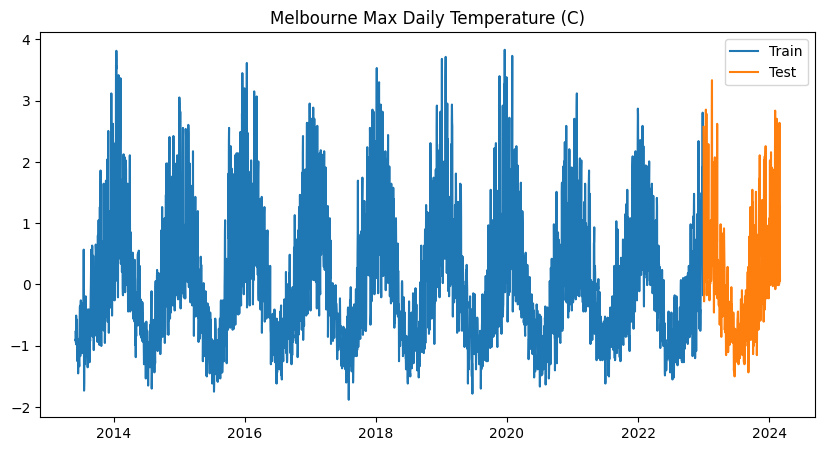

In [4]:
fig = plt.figure(figsize=(10, 5))
_ = plt.title("Melbourne Max Daily Temperature (C)")

_ = plt.plot(dataset_train.dataset.index, dataset_train.dataset.values[:, 1])
_ = plt.plot(dataset_test.dataset.index, dataset_test.dataset.values[:, 1])

_ = plt.legend(["Train", "Test"])
# Note:see here how we can just directly access the data from the dataset class

### Res-MLP Predictor

In [5]:
# Define a residual MLP block
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(input_size)
        # First fully connected layer that reduces the dimensionality by half
        self.fc1 = nn.Linear(input_size, input_size // 2)
        
        # Layer normalization after the first fully connected layer
        self.norm2 = nn.LayerNorm(input_size // 2)
        # Second fully connected layer that outputs the desired output size
        self.fc2 = nn.Linear(input_size // 2, output_size)
        
        # Skip connection layer to match the output size
        self.fc3 = nn.Linear(input_size, output_size)

        # Activation function
        self.act = nn.ELU()

    def forward(self, x):
        # Apply normalization and activation function to the input
        x = self.act(self.norm1(x))
        # Compute the skip connection output
        skip = self.fc3(x)
        
        # Apply the first fully connected layer, normalization, and activation function
        x = self.act(self.norm2(self.fc1(x)))
        # Apply the second fully connected layer
        x = self.fc2(x)
        
        # Add the skip connection to the output
        return x + skip


class ResMLP(nn.Module):
    def __init__(self, seq_len, output_size, num_blocks=1):
        super(ResMLP, self).__init__()
        
        # Compute the length of the sequence data
        seq_data_len = seq_len * 2
        
        # Define the input MLP with two fully connected layers and normalization
        self.input_mlp = nn.Sequential(
            nn.Linear(seq_data_len, 4 * seq_data_len),
            nn.ELU(),
            nn.LayerNorm(4 * seq_data_len),
            nn.Linear(4 * seq_data_len, 128)
        )

        # Define the sequence of residual blocks
        blocks = [ResBlockMLP(128, 128) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        
        # Final output fully connected layer
        self.fc_out = nn.Linear(128, output_size)
        # Activation function
        self.act = nn.ELU()

    def forward(self, input_seq):
        # Reshape the input sequence to be a flat vector
        input_seq = input_seq.reshape(input_seq.shape[0], -1)
        # Pass the input through the input MLP
        input_vec = self.input_mlp(input_seq)

        # Pass the output through the residual blocks and activation function
        x = self.act(self.res_blocks(input_vec))
        
        # Compute the final output
        return self.fc_out(x)

In [6]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# Create an instance of the ResMLP model
# - seq_len is the number of days the model takes as input (days_in)
# - output_size is the number of outputs the model predicts (2: Max Daily Temperature and Rainfall)
weather_mlp = ResMLP(seq_len=days_in, output_size=2).to(device)

# Initialize the optimizer
# - Use Adam optimizer which is an adaptive learning rate optimization algorithm
# - It updates the weights of the model based on the computed gradients
# - weather_mlp.parameters() returns all the parameters of the model
# - lr is the learning rate, which controls how much to change the model in response to the estimated error
optimizer = optim.Adam(weather_mlp.parameters(), lr=learning_rate)

# Define the loss function
# - Mean Squared Error (MSE) is used as the loss function
# - MSE calculates the average of the squares of the errors (differences between predicted and actual values)
loss_fn = nn.MSELoss()

# Initialize a list to log the training loss over epochs
training_loss_logger = []

In [7]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in weather_mlp.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 51666 (Approximately 0 Million) Parameters!


In [8]:
# Iterate over the number of epochs
for epoch in trange(nepochs, desc="Epochs", leave=False):
    # Set the model to training mode
    weather_mlp.train()
    
    # Iterate over the training data loader
    for day, month, data_seq in tqdm(data_loader_train, desc="Training", leave=False):
        
        # Extract the initial sequence block to be used as input for the model
        seq_block = data_seq[:, :days_in].to(device)
        
        # Initialize the loss for the current batch
        loss = 0
        
        # Iterate over the remaining sequence to predict the next day values
        for i in range(day_range - days_in):
            # Get the target sequence block for the next day
            target_seq_block = data_seq[:, i + days_in].to(device)
            
            # Make predictions using the model
            data_pred = weather_mlp(seq_block)
            
            # Accumulate the loss for the current prediction
            loss += loss_fn(data_pred, target_seq_block)
            
            # Update the input sequence by removing the oldest date and adding the new prediction
            # Detach the new sequence to prevent backpropagation through the old sequence
            seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1).detach()

        # Average the accumulated loss over the number of steps
        loss /= i + 1
        
        # Zero the gradients before performing backpropagation
        optimizer.zero_grad()
        
        # Perform backpropagation to compute gradients
        loss.backward()
        
        # Update the model parameters using the optimizer
        optimizer.step()
        
        # Log the training loss for later analysis
        training_loss_logger.append(loss.item())

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

### Plot Train Loss

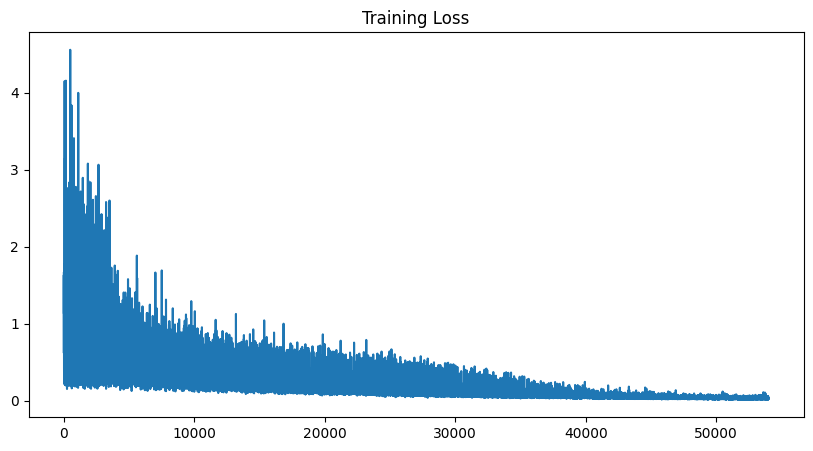

In [9]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger)
_ = plt.title("Training Loss")

### Run Autoregressive Prediction Roll-Out

In [10]:
# Convert the test dataset values to a PyTorch tensor
data_tensor = torch.FloatTensor(dataset_test.dataset.values)

# Initialize a list to log predictions
log_predictions = []

# Set the model to evaluation mode
weather_mlp.eval()

# Disable gradient calculation for the prediction process
with torch.no_grad():
    # Extract the initial sequence block to be used as input for the model
    # - unsqueeze(0) adds a batch dimension to the input
    seq_block = data_tensor[:days_in, :].unsqueeze(0).to(device)
    
    # Iterate over the sequence to predict the next day values
    for i in range(data_tensor.shape[0] - days_in):
        # Make predictions using the model
        data_pred = weather_mlp(seq_block)
        
        # Log the prediction
        log_predictions.append(data_pred.cpu())
        
        # Update the input sequence by removing the oldest date and adding the new prediction
        seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1)

# Concatenate the logged predictions into a single tensor
predictions_cat = torch.cat(log_predictions)

# Unnormalize the predictions using the dataset's standard deviation and mean
un_norm_predictions = (predictions_cat * dataset_test.std) + dataset_test.mean

# Unnormalize the original data using the dataset's standard deviation and mean
un_norm_data = (data_tensor * dataset_test.std) + dataset_test.mean

# Trim the initial sequence from the unnormalized data to match the length of predictions
un_norm_data = un_norm_data[days_in:]

In [11]:
test_mse = (un_norm_data - un_norm_predictions).pow(2).mean().item()
print("Test MSE value %.2f" % test_mse)

Test MSE value 44.45


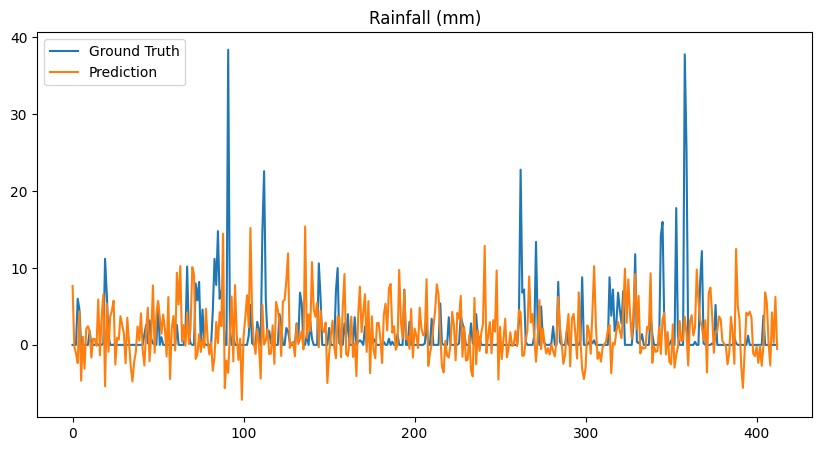

In [12]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(un_norm_data[:, 0])
_ = plt.plot(un_norm_predictions[:, 0])
_ = plt.title("Rainfall (mm)")

_ = plt.legend(["Ground Truth", "Prediction"])

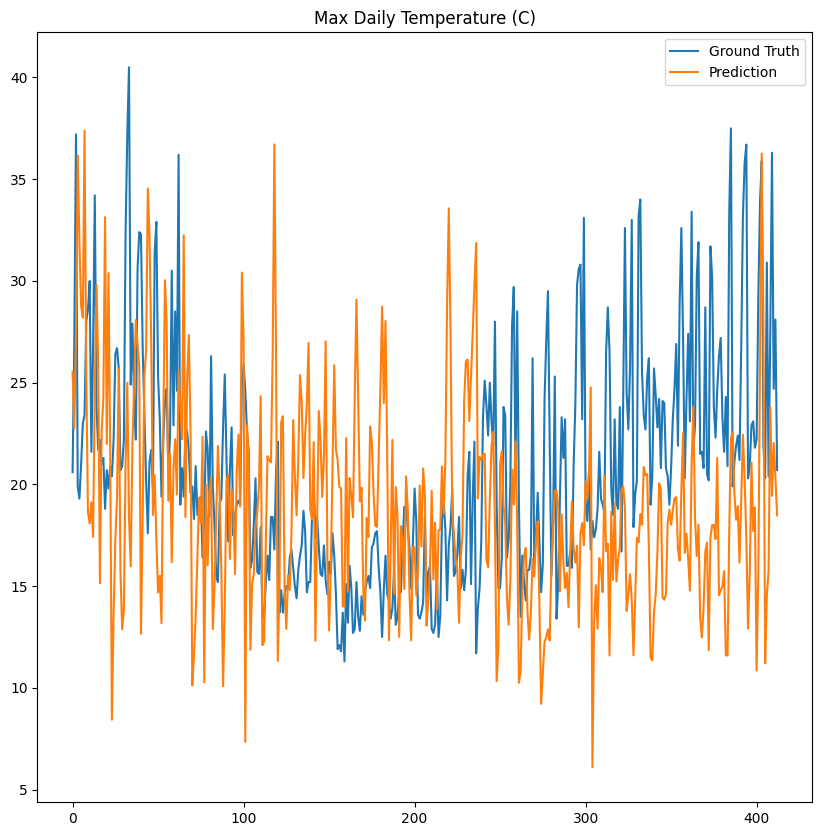

In [13]:
_ = plt.figure(figsize=(10, 10))
_ = plt.plot(un_norm_data[:, 1])
_ = plt.plot(un_norm_predictions[:, 1])
_ = plt.title("Max Daily Temperature (C)")

_ = plt.legend(["Ground Truth", "Prediction"])